# Notebook 2 - Explaining Speech Emotion Recognition - Part 2
##  XAI for Affective Computing with Counterfactuals (SoSe2024)

In this second part of our second Jupyter Notebook assignment, you will attempt to generate SHAP based feature attribution explations for a speech emotion recognition (SER) task with spectrograms as input to a CNN.

To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.

Make sure to read the Notebook 2 section of the **README** beforing starting this notebook for all installation instructions.

## Notebook Setup

In [1]:
# %load_ext autoreload
# %autoreload 2

##### Import necessary libraries

(see README for necessary package installations if you receive a `module not found` error.

In [2]:
import os
from pathlib import Path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas as pd
import numpy as np

import librosa

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

import tensorflow as tf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import shap_utils

from IPython.display import Audio
import IPython
import warnings
warnings.filterwarnings('ignore')
tf.config.list_physical_devices('GPU')

[]

## Feature Attribution using SHAP

In this part of the Notebook, you will generate Shaply Value based feature attribution explanations for predictions from a SER Convolutional Neural Network (CNN) that uses log mel-spectrograms as input. To do this, you will be using the [SHAP Python Package](https://shap.readthedocs.io/en/latest/index.html), which is an extensive implementation of explantion methods bsaed on Shapley values.  

Before getting started with this task make sure to review the documention of SHAP.

### Data and Model


#### Load the Data
First we need to load our datast.  For this task, we will be using the audio portion of the [Ravdess dataset](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio).  

In this task, we provide you with a dataframe of audio information in the form of a pandas dataframe. Then we will extract spectrogams  The mel-frequency spectrograms are generated using [librosa's](https://librosa.org/doc/main/index.html) [`melspectrogram`](https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html) function. 

In [3]:
# feature extraction functions
def get_log_melspec(data, sample_rate, silence_thresh=25):
    """
    Function to generate mel-spectrograms.  First, we trim silence and pad audio clips to all be the same length
    :param data: 
    :param sample_rate: 
    :param silence_thresh: 
    :return: spectrogram
    """
    trimmed, _ = librosa.effects.trim(data, top_db=silence_thresh)
    padded = np.pad(trimmed, (int(16000*2.5-len(trimmed)//2), int(16000*2.5-len(trimmed)//2)), 'constant')
    mel = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
    return librosa.power_to_db(mel, ref=np.max)

def load_melspec(row):
    # down sample all audio to 16000
    a, sr = librosa.load(row['path'], sr=16000)
    return get_log_melspec(a, sr, silence_thresh=55)

In [4]:
LABELS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

# load the dataframe
df_test = pd.read_csv('../data/ravdess/features/radvess_melspec_test.csv')

# Update audio paths to current locations
audio_path = Path('../data/ravdess/audio_clips')
def update_paths(row):
    return str(audio_path / Path(row.path).name)
df_test.path = df_test.apply(update_paths, axis='columns')

# extract mel spectrograms
df_test['feats'] = df_test.apply(load_melspec, axis=1)

#### Review a sample audio clip

In [5]:
audio_sample = df_test.sample(1).iloc[0]
audio_sample

Unnamed: 0                                                     642
actor                                                           15
emotion                                                          0
intensity                                                        1
path             ../data/ravdess/audio_clips/03-01-01-01-01-02-...
emotion_label                                              neutral
feats            [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...
Name: 42, dtype: object

In [6]:
Audio(audio_sample['path'])

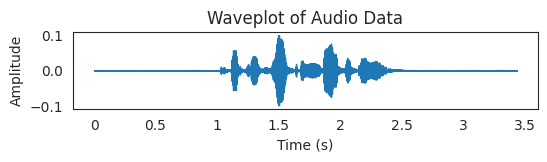

22050


In [7]:
# load file and plot waveform
y, sr = librosa.load(audio_sample['path'])
# Create wave plot
plt.figure(figsize=(6, 1))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot of Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()
print(sr)

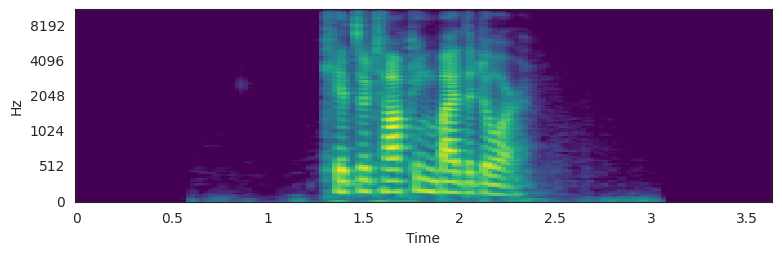

In [8]:
# visualize mel-spectrogram
log_mel = audio_sample.feats
plt.figure(figsize=(9,2.5))
librosa.display.specshow(log_mel, sr=sr, x_axis='time', y_axis='mel', cmap = 'viridis', hop_length=512, n_fft=2048)

#### Load the CNN model 

In [9]:
def get_dataset(df, feats_col, labels_col):
    """ Functcion to create a tensorflow dataset from our dataframes
    :param df: 
    :param feats_col: 
    :param labels_col: 
    :return: 
    """
    labels = df[labels_col].values
    labels = tf.one_hot(labels, depth=8)
    
    # convert from object array to floats
    feats = df[feats_col]
    feats = [f.astype(float) for f in feats]
    feats = np.array(feats)
    
    ds_feats = tf.data.Dataset.from_tensor_slices(feats)
    ds_labels = tf.data.Dataset.from_tensor_slices(labels)
    
    ds = tf.data.Dataset.zip(ds_feats, ds_labels)
    
    return ds

In [10]:
# make sure you've downloaded the models from Moodle (see README instructions for Notebook I)
model = tf.keras.models.load_model('../models/ravdess/simplenet')

#### Evaluate model
Next we will evaluate the loaded model to ensure it is working as expected.  You should get around $45.67\%$ accuracy. While this is not a perfect classifier is well above random guessing which is $1 / 8 * 100 = 12.5$ accuracy

We also generate the predictions of the model for the dataset, and store them in `Y_img_pred`.

In [11]:
# setup test dataloader
ds_test = get_dataset(df_test, 'feats', 'emotion').batch(128).prefetch(tf.data.AUTOTUNE)

loss, acc = model.evaluate(ds_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# generate predictions for later user
preds = model.predict(ds_test)
df_test['emotion_pred'] = np.argmax(preds, axis=1)

3/3 - 1s - loss: 2.5754 - accuracy: 0.4567 - 835ms/epoch - 278ms/step
Restored model, accuracy: 45.67%
3/3 [==============================] - 1s 201ms/step


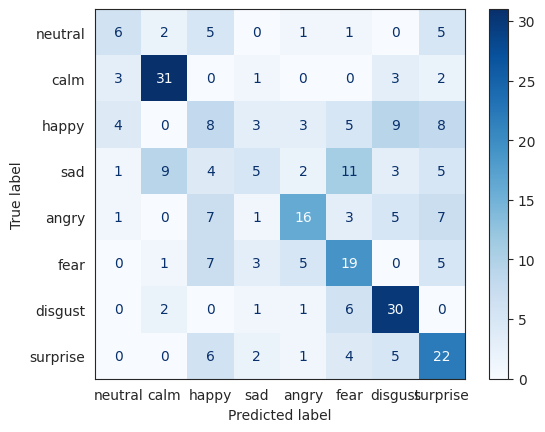

In [12]:
cm = confusion_matrix(df_test['emotion'], df_test['emotion_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap='Blues')
plt.grid(False)

### Task 2: Generate Feature Attribution Explanations using SHAP

In this part of the notebook, you will generate feature attribution explanations (aka saliency maps) using the Python Library, [SHAP (SHapley Additive exPlanations) ](https://shap.readthedocs.io/en/latest/index.html). Make sure to review the documentation and getting started information.

#### Review the Dataset

First let's review some samples to select a few examples.  

Below you can load a random set of samples and then listen to the audio clips.  Make sure to note down the index value for sample that you would like to keep for analysis.  

(note: the audio display function doesn't work if your using PyCharm)

(note you can also filter by emotion if  you prefer. By filtering the data frame, for example: `df_test[df_test['emotion_label'] == 'happy']`

In [13]:
audio_samples = df_test.sample(5, random_state=0)
audio_samples

,Unnamed: 0,actor,emotion,intensity,path,emotion_label,feats,emotion_pred
208,1228,11,5,2,../data/ravdess/audio_clips/03-01-06-02-02-01-...,fear,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",2
188,1208,11,3,1,../data/ravdess/audio_clips/03-01-04-01-01-02-...,sad,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",6
12,612,15,7,2,../data/ravdess/audio_clips/03-01-08-02-02-01-...,surprise,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",7
221,1241,11,1,2,../data/ravdess/audio_clips/03-01-02-02-01-01-...,calm,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",1
239,1259,11,0,1,../data/ravdess/audio_clips/03-01-01-01-02-02-...,neutral,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",5


In [14]:
for idx, sample in audio_samples.iterrows():
    print(f'Index: {idx} - Emotion: {sample.emotion_label} | Prediction: {LABELS[sample.emotion_pred]}')
    print(sample.path)
    IPython.display.display(IPython.display.Audio(sample.path))

Index: 208 - Emotion: fear | Prediction: happy
../data/ravdess/audio_clips/03-01-06-02-02-01-11.wav


Index: 188 - Emotion: sad | Prediction: disgust
../data/ravdess/audio_clips/03-01-04-01-01-02-11.wav


Index: 12 - Emotion: surprise | Prediction: surprise
../data/ravdess/audio_clips/03-01-08-02-02-01-15.wav


Index: 221 - Emotion: calm | Prediction: calm
../data/ravdess/audio_clips/03-01-02-02-01-01-11.wav


Index: 239 - Emotion: neutral | Prediction: fear
../data/ravdess/audio_clips/03-01-01-01-02-02-11.wav


#### Task 2.0: Select Your Samples
- After reviewing the samples above, select four that you would like to generate explanations for.

In [15]:
#### Enter the Indexes Here ### 
###############################
# you will use this array later in the task
idxs = [1,2,3,4]

#### Task 2.1: Feature Attribution with SHAP

Now it's time to generate the feature attribution values

In [16]:
# First we have to import shap and add a few fixes for our model
import shap

# fixes issues with running deep explainer on our model
# https://github.com/slundberg/shap/issues/1761
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.linearity_1d(0)

##### Task 2.1.1 Setup the SHAP Explainer 

You can choose to use either the [PartitionExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.PartitionExplainer.html), which is SHAP approximation of LIME. Or the [DeepExplainer](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) which is an implementation of DeepLIFT

Generate the SHAP values for each of the four images you selected above.  You can review the [SHAP image tutorials](https://shap.readthedocs.io/en/latest/image_examples.html) for help. (Although we are not using images, the main ideas with spectrograms and CNNs hold).

In [17]:
##### YOUR CODE GOES HERE #####
###############################
# create a DeepExplainer object
# Sample of the data for the explainer
background = df_test['feats'].sample(n=100, random_state=0).tolist()

# Convert background to the right shape
background = np.array(background)
background = np.stack(background, axis=0)

if len(background.shape) == 3:
    print('Expanding dimensions')
    background = np.expand_dims(background, axis=-1)

# Create the DeepExplainer object
explainer = shap.DeepExplainer(model, background)

Expanding dimensions


In [18]:
# Get the samples to explain
samples_to_explain = df_test.iloc[idxs]['feats'].tolist()

# Convert to the right shape
samples_to_explain = np.array(samples_to_explain)
samples_to_explain = np.stack(samples_to_explain, axis=0)

# Reshape to add the channel dimension if missing
if len(samples_to_explain.shape) == 3:
    print('Expanding dimensions')
    samples_to_explain = np.expand_dims(samples_to_explain, axis=-1)

# Calculate SHAP values
shap_values = explainer.shap_values(samples_to_explain)


Expanding dimensions


In [21]:
shap_values_transformed = shap_values[:, :, :, 0]

##### Task 2.1.2: Use the Explainer to Feature Attribution Maps

Generate counterfacutal explanations for each of your selected samples. 

Unfortunately, one of the downsides to this approach is computation time. If you're not running this notebook on a GPU you may have to be a bit patient when calculating the SHAP  values. 

In [22]:
##### YOUR CODE GOES HERE #####
###############################
counterfactuals = []

for i, idx in enumerate(idxs):
    sample = samples_to_explain[i]
    shap_value = shap_values_transformed[i]
    
    # Calculate the counterfactual by flipping the sign of SHAP values
    counterfactual = sample - shap_value
    
    counterfactuals.append(counterfactual)
    
    # print(f"Counterfactual for Sample index: {idx}")
    # shap.initjs()
    # shap.force_plot(explainer.expected_value, -shap_value, counterfactual)
    # plt.show()

Expected Value: [0.07068781 0.16354826 0.13606393 0.06633171 0.11928128 0.15853864
 0.14133656 0.14421178]
SHAP Values: [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

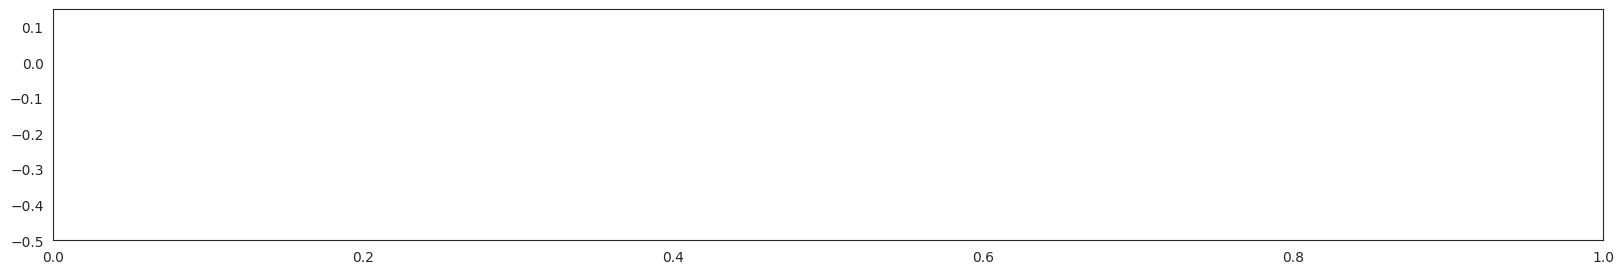

In [27]:
#shap.initjs()
print(f"Expected Value: {explainer.expected_value}")
print(f"SHAP Values: {shap_values_transformed[0]}")

shap.force_plot(explainer.expected_value, -shap_values_transformed[0][0], counterfactuals[0][0], matplotlib=True)

##### Task 2.1.3 Visualize the Explanations

Now that we have calculated the SHAP values, lets visualize them. Unfortunately, the SHAP API approach does not work well for spectrograms.  So I have implemented a plotting function that plots the original spectrogram and SHAP values for one class and one input sample.  

See `shap_utils.plot_shap_spec` for details

In addition to plotting the SHAP values, include the Audio sample for comparision. You can use the function:
```python
IPython.display.display(IPython.display.Audio('audiopath'))
```

Bonus: Modify the function to plot more than one set of SHAP values for each explanation.

In [19]:
##### YOUR CODE GOES HERE #####
###############################


#### Task 2.2 Describe your observations

1. Which method did you choose and why?
2. How understanable are the explanations?
3. Were you able to identify any pattern in the explanations that help improve your understanding of the prediction?
4. How could we generate global explanations from these local explanations?
5. Describe any other insight or perspectives that you have drawn from this example

#### Task 2.3 Evaluate SHAP Values
One of the main features of SHAP values is that they sum up to the difference between the expected model output (i.e. the average of the predictions on the 'background sample') and the current output.

In other words,

$$
   \Sigma shap(x) = f(x) - E[f(X)]
$$

where $f(x)$ is our model, $x$ is the current instance being explained, and $X$ is the background sample (in our case the data in `X_xai`)

Using the generated SHAP values and the generated model predictions, show that this is true for your explainer.

In [20]:
##### YOUR CODE GOES HERE #####
###############################